In [1]:
import os
import glob
import collections
import random

import numpy as np
from numpy import loadtxt
import pandas as pd
import scipy

import gseapy as gp #paper for GSEApy: https://academic.oup.com/bioinformatics/article/39/1/btac757/6847088
from gseapy import gseaplot

import matplotlib.pyplot as plt

### Variables requiring user input - change as needed

In [2]:
gene_query_set_size = 500 #500 is recommended for optimal coverage without introducing statistical bias
GSEAresultsfiletitle = '\gseapy.gene_set.prerank.report.csv' #this changes if GSEApy is updated

#probe level analysis variables
zscorebool = True #set to True if you want to run z-score
Tscorebool = True #set to True if you want to run T-score
GSEAgeneIDbool = True #set to True if you want to run GSEA to identify probes of interest
genepanelbool = True #set to True if you want to define panels
moregenedatasetsbool = True #set to True if you have additional datasets for meta-analysis
randomgenemodel = True #set to True if you want ran random model for additional datasets

### Functions

In [3]:
def data_prep(input_file_dir, output_path):
    global zscorebool, dataset_list, identification_datasets

    
    input_path_list = []    

    #get list of subdirectories - should only have "input" folder in the directory
    for path in glob.glob(f'{cwd}/*/**/', recursive=True):
        input_path_list.append(path)

    for input_path in input_path_list: #loop for more than just 1 input file (BioMOMA)
        path_split_list = input_path.split("\\")
        input_file_name = path_split_list[-2]    
        input_file_name = input_file_name[:len(input_file_name) - 5]

        #establish path variable for output directory
        all_files = []
        dataset_list = []
        samples_data_list = []

        #iterate input directory to generate a list of all files (all_files)
        for path in os.listdir(input_path):
            if os.path.isfile(os.path.join(input_path, path)): #check if current path is a file
                all_files.append(path)

        #check to see files are properly paired
        compare_dataset_IDs = []
        for file_name in all_files:
            if "samples" in file_name:
                file_name = file_name[:-11:]
                samples_data_list.append(file_name)
            elif "data" in file_name:
                file_name = file_name[:-8:]
                dataset_list.append(file_name)

        #sorting both the lists so order does not impede check
        samples_data_list.sort()
        dataset_list.sort()
        if samples_data_list != dataset_list: #using == to check if lists are equal
            print('Missing dataset or samples data file.')


        #PANEL IDENTIFICATION -------------------------------------------------------------------------------------------------
        number_ID_datasets = 0 #number of datasets that store identification data (must end up being 1 or 2)
        identification_datasets = [] #list of identification datasets


        for dataset in dataset_list:
            if dataset[-2:] == "ID": #determine if file_name is identification dataset
                if number_ID_datasets == 0:
                    probe_ID_file1 = "\\" + dataset + "data.txt" #name of first file that stores identification data
                    sample_ID_file1 = "\\" + dataset + "samples.txt" #name of file that stores sample identification data for first file
                    output_path1 = output_path + '\GSEAID' + dataset #establish path variable for identification output directory
                    output_path2 = output_path + '\GSEAID2' + dataset #establish path variable for identification output directory
                    print('The identification dataset is', dataset[:-2])
                    identification_datasets.append(dataset)
                if number_ID_datasets == 1:
                    probe_ID_file2 = "\\" + dataset + "data.txt" #name of second file, if needed, that stores identification data
                    sample_ID_file2 = "\\" + dataset + "samples.txt" #name of file that stores sample identification data for second file        
                    output_path2 = output_path + '\GSEAID' + dataset #rename path variable for identification output directory
                    print('The second identification dataset is', dataset[:-2])
                    identification_datasets.append(dataset)

                number_ID_datasets = number_ID_datasets + 1
        print()

        if zscorebool == True:
            #create output directories
            if not os.path.exists(output_gene_file_dir):
                os.mkdir(output_gene_file_dir)
            if not os.path.exists(output_path1):
                os.mkdir(output_path1)
            if not os.path.exists(output_path2):
                os.mkdir(output_path2)    

        #load first identification dataset as dataframe and format it for use    
        probe_ID_path1 = input_path + probe_ID_file1   
        raw_df1 = pd.read_csv(probe_ID_path1, low_memory = False, index_col = None, header = None, sep = '\t')
        raw_df1.set_index(raw_df1.columns[0], inplace=True)

        raw_df1_sample_list = raw_df1.iloc[0].tolist()
        raw_df1.columns = raw_df1.iloc[0]
        raw_df1.drop(raw_df1.index[0], inplace = True)

        #load sample information for first identification dataset as a list and format it for use
        sample_ID_path1 = input_path + sample_ID_file1
        sample_file1 = open(sample_ID_path1, "r")
        samples1 = sample_file1.read()
        sample_list1 = samples1.split("\t")
        sample_list1[-1] = sample_list1[-1].strip()

        if len(sample_list1) == raw_df1.shape[1]:
            print('Total number of samples confirmed for the first identification dataset.')
            print()

        if number_ID_datasets == 2:
            #load second identification dataset as dataframe and format it for use
            probe_ID_path2 = input_path + probe_ID_file2
            raw_df2 = pd.read_csv(probe_ID_path2, low_memory = False, index_col = None, header = 0, sep = '\t')
            raw_df2.set_index(raw_df2.columns[0], inplace=True)

            #load sample information for second identification dataset as a list and format it for use
            sample_ID_path2 = input_path + sample_ID_file2    
            sample_file2 = open(sample_ID_path2, "r")
            samples2 = sample_file2.read()
            sample_list2 = samples2.split("\t")
            sample_list2[-1] = sample_list2[-1].strip()

            if len(sample_list2) == raw_df2.shape[1]:
                print('Total number of samples confirmed for the second identification dataset.')
                print()
                
        #define df1 and df2
        df1 = pd.DataFrame()
        df2 = pd.DataFrame()

        #define empty variables
        control_cols1 = []
        control_cols2 = []
        experimental_cols1 = []
        experimental_cols2 = []

        num = 0 #sample counter
        if number_ID_datasets == 1:    
            #determine column index (location) of control and experimental samples for first dataset
            total_controls = []
            sample_control_list = []
            total_experimental = []
            sample_experimental_list = []

            #these variables are lists of sample indecies from df
            temp_control_cols1 = []
            temp_control_cols2 = []
            temp_experimental_cols1 = []
            temp_experimental_cols2 = []

            for i in sample_list1:
                if i == '0':
                    total_controls.append(num)
                    sample_control_list.append(raw_df1_sample_list[num])
                else:
                    total_experimental.append(num)
                    sample_experimental_list.append(raw_df1_sample_list[num])
                num = num + 1

            #assign sample identities    
            control_midpt = int(len(total_controls) / 2)
            temp_control_cols1 = total_controls[:control_midpt]
            temp_control_cols2 = total_controls[control_midpt:]

            experimental_midpt = int(len(total_experimental) / 2)
            temp_experimental_cols1 = total_experimental[:experimental_midpt]    
            temp_experimental_cols2 = total_experimental[experimental_midpt:]    

            #assign dataframes
            name_num = 0
            num = 0
            for i in temp_experimental_cols1:
                temp_col = raw_df1.iloc[:, i]       
                sample_ID = sample_experimental_list[name_num]
                df1[sample_ID] = temp_col
                experimental_cols1.append(num)
                name_num = name_num + 1
                num = num + 1

            name_num = 0
            for i in temp_control_cols1:
                temp_col = raw_df1.iloc[:, i]
                sample_ID = sample_control_list[name_num]
                df1[sample_ID] = temp_col
                control_cols1.append(num)
                name_num = name_num + 1
                num = num + 1

            name_num = len(experimental_cols1)
            num = 0
            for i in temp_experimental_cols2:
                temp_col = raw_df1.iloc[:, i]
                sample_ID = sample_experimental_list[name_num]
                df2[sample_ID] = temp_col
                experimental_cols2.append(num)
                name_num = name_num + 1
                num = num + 1

            name_num = len(control_cols1)
            for i in temp_control_cols2:
                temp_col = raw_df1.iloc[:, i]
                sample_ID = sample_control_list[name_num]
                df2[sample_ID] = temp_col
                control_cols2.append(num)
                name_num = name_num + 1
                num = num + 1

        else:    
            #assign sample identities
            for i in sample_list1:
                if i == '0':
                    control_cols1.append(num)
                else:
                    experimental_cols1.append(num)
                num = num + 1

            num = 0
            for i in sample_list2:
                if i == '0':
                    control_cols2.append(num)
                else:
                    experimental_cols2.append(num)
                num = num + 1

                #assign dataframes
                df1 = raw_df1
                df2 = raw_df2

        #check this output to ensure proper column selection
        print('Number of control samples for identification signature 1:', len(control_cols1))
        for l in control_cols1:
            print(df1.columns[l])
        print()
        print('Number of experimental samples for identification signature 1:', len(experimental_cols1))
        for l in experimental_cols1:
            print(df1.columns[l])
        print()

        print('Number of control samples for identification signature 2:', len(control_cols2))
        for l in control_cols2:
            print(df2.columns[l]) 
        print()
        print('Number of experimental samples for identification signature 2:', len(experimental_cols2))
        for l in experimental_cols2:
            print(df2.columns[l])
        print()
    return df1, df2, output_path1, output_path2, control_cols1, experimental_cols1, control_cols2, experimental_cols2

In [4]:
#function zscore normalizes data across all samples (columns) per gene (row) 
def zscore(df, datasetnum, loc):
    df.dropna(inplace = True)
    df.reset_index(inplace=True)
    totalrows = df[df.columns[0]].count()
    df2 = pd.DataFrame()
    tempnum = 0 #row counter variable
    
    while tempnum < totalrows:
        zscorearray = []
        temparray = df.iloc[tempnum].to_numpy()
        geneID = temparray[0]
        temparray = np.delete(temparray, 0, 0)
        temparray = temparray.astype(np.float64)

        mean = np.mean(temparray)
        std = np.std(temparray)

        for value in temparray:
            tempz = (value - mean) / std
            zscorearray = np.append(zscorearray, tempz)
        tempseries = pd.Series(zscorearray, name = geneID)
        df2 = pd.concat([df2, tempseries.to_frame().T])
        
        if tempnum % 1000 == 0:
            print('Z-scoring gene #' + str(tempnum))
        tempnum = tempnum + 1
        
    df2copy = df2
    header = list(df.head(0))
    header.pop(0)
    df2.columns = header
    filename = loc + '\Zscoredata.txt'
    df2.to_csv(filename, sep='\t', index=True)
    print('Z-score done for dataset ' + str(datasetnum))
    print()
    return df2copy

In [5]:
#function Tscores each gene between defined control and experimental groups
def Tscore(df, controlcols, experimentalcols, datasetnum, loc):
    dfstat = pd.DataFrame()
    dfpval = pd.DataFrame()
    tempnum = 0 #row counter variable
    
    for r in df.iterrows():
        geneID = r[0]
        row = r[1]
        controlvals = []
        experimentalvals = []
        for iter in controlcols:
            controlvals.append(row[iter])
        for iter in experimentalcols:
            experimentalvals.append(row[iter])
    
        stat, pval = scipy.stats.ttest_ind(experimentalvals, controlvals, equal_var=False)
        tempstatseries = pd.Series(stat, name = geneID)
        temppvalseries = pd.Series(pval, name = geneID)
        
        dfstat = pd.concat([dfstat, tempstatseries.to_frame().T])
        dfpval = pd.concat([dfpval, temppvalseries.to_frame().T])
        
        if tempnum % 1000 == 0:
            print('T-scoring gene #' + str(tempnum))
        tempnum = tempnum + 1
        
    dfstat.columns = ['Tscore']
    df2 = pd.concat([dfstat, dfpval], axis = 1)
    df2.columns = ['Tscore', 'pval']
    filename = loc + '\Tscoredata.txt'
    df2.to_csv(filename, sep='\t', index=True)
    dfstat = dfstat.sort_values(by=['Tscore'], ascending=False)
    print('T-score done for dataset ' + str(datasetnum))
    print()
    return dfstat

In [6]:
#function removes duplicate genes by finding the highest abs(Tscore) 
#function then remove genes without Tscores and adjusts centers signature
def dups(signature, datasetnum, loc):
    sigdict = {}
    num = 0

    for gene, row in signature.iterrows():
        tempTscore = signature.iloc[num]['Tscore']
        if np.isnan(tempTscore) == False:
            if gene in sigdict:   
                if abs(tempTscore) > abs(row['Tscore']):
                    sigdict.update({gene:tempTscore})
            else:
                sigdict.update({gene:row['Tscore']})
        else:
            print(gene, tempTscore)
        num = num + 1

    shortsig = pd.DataFrame(list(sigdict.items()),columns = ['Gene','Tscore']) 
    
    #center signature
    midptloc = int((len(shortsig.index)) / 2)
    midTscore = shortsig.iloc[midptloc] ['Tscore']
    newTscore = []
    
    for i, row in shortsig.iterrows():
        newval = row['Tscore'] - midTscore
        newTscore.append(float(newval))
    shortsig['Tscoreadjusted'] = newTscore
    shortsig.set_index("Gene", inplace = True)
    print('Tscores for dataset', str(datasetnum), 'were adjusted by', (-1*midTscore))
    print()
    
    filename = loc + '\signature.txt'
    shortsig.to_csv(filename, sep='\t', index=True)
    shortsig.drop('Tscore', axis=1, inplace = True)
    shortsig.rename(columns={"Tscoreadjusted": "Tscore"}, inplace=True)
    return shortsig

In [7]:
#function generates query sets from tails of 2 signatures established in prior functions
def query_generator(df, querysetsize, datasetnum, loc, query_num):
    global GSEAgeneIDbool, GSEApathIDbool
    
    dfquery = pd.DataFrame()
    if query_num == 1:
        dfhighest = df['Tscore'].nlargest(querysetsize)
        dflowest = df['Tscore'].nsmallest(querysetsize)
    if query_num == 2:
        dfhighest = df['NES'].nlargest(querysetsize)
        dflowest = df['NES'].nsmallest(querysetsize)

    highestlist = pd.Index.tolist(dfhighest.index)
    lowestlist = pd.Index.tolist(dflowest.index)
    
    highestlist.insert(0, ('positivetail' + str(datasetnum)))
    highestlist.insert(1, ('spacer'))
    
    lowestlist.insert(0, ('negativetail' + str(datasetnum)))
    lowestlist.insert(1, ('spacer'))
    
    highestSeries = pd.Series(highestlist)
    lowestSeries = pd.Series(lowestlist)
    dfquery = pd.concat([highestSeries, lowestSeries], axis = 1)
    dfquery = dfquery.T
    print('Query set', str(datasetnum), 'generation done!')
    print()
    return dfquery

In [8]:
#function performs GSEA
def prerank_GSEA(refsigdf, gene_sets, outputdir, size):
    #create GSEA results output directory
    new_output_dir = outputdir + '\GSEAresults'
    if not os.path.exists(new_output_dir):
        os.mkdir(new_output_dir)
    
    #run GSEA
    preresult = gp.prerank(rnk=refsigdf,
                     gene_sets=gene_sets,
                     min_size=15,
                     max_size=size,
                     permutation_num=1000,
                     outdir=new_output_dir,
                     seed=6,
                     verbose=False, 
                    )
    
    #print GSEA results to screen
    print(preresult.res2d.head(5))
    print()

### Main program

In [9]:
cwd = os.getcwd() #gets current location of program file (.jpynb)

output_gene_file_dir = cwd + "\\" + "geneleveloutput" #name of directory to store output data

In [10]:
import warnings
warnings.filterwarnings('ignore')

#### Z-score code - this section of blocks determine if zscores need to be calculated and imports them if available

In [11]:
if zscorebool == True: #split data into 4 groups and normalize data 
    input_file_dir = cwd + "\\" + "input" #name of directory to store input data
    df1, df2, output_path1, output_path2, control_cols1, experimental_cols1, control_cols2, experimental_cols2 = data_prep(input_file_dir, output_gene_file_dir)
    
    #call function to zscore data
    normalized_df1 = zscore(df1, 1, output_path1)
    normalized_df2 = zscore(df2, 2, output_path2)

The identification dataset is GSE32863v1
The second identification dataset is GSE32863v2

Total number of samples confirmed for the first identification dataset.

Total number of samples confirmed for the second identification dataset.

Number of control samples for identification signature 1: 19
Adjacent non-tumor lung tissue 05L12_N (expression)
Adjacent non-tumor lung tissue 05L13_N (expression)
Adjacent non-tumor lung tissue 05L19_N (expression)
Adjacent non-tumor lung tissue 05L27_N (expression)
Adjacent non-tumor lung tissue 05L32_N (expression)
Adjacent non-tumor lung tissue 05L34_N (expression)
Adjacent non-tumor lung tissue 05L39_N (expression)
Adjacent non-tumor lung tissue 05L4_N (expression)
Adjacent non-tumor lung tissue 05L40_N (expression)
Adjacent non-tumor lung tissue 05L43_N (expression)
Adjacent non-tumor lung tissue 05L45_N (expression)
Adjacent non-tumor lung tissue 05L47_N (expression)
Adjacent non-tumor lung tissue 05L49_N (expression)
Adjacent non-tumor lung tis

In [12]:
#establish a list of output folders
output_path_list = [] #list of output dictionary folders

for path in glob.glob(f'{output_gene_file_dir}/*/', recursive=True): #get list of subdirectories for \\geneleveloutput directory
    output_path_list.append(path)

In [13]:
if zscorebool == False:
    if Tscorebool == True: #bring in zscore files if needed for T-score function
        input_file_dir = cwd + "\\" + "input" #name of directory to store input data        
        count = 1 #local folder counter
        for i in output_path_list:
            temp_output_file_dir = i + "\\" + "Zscoredata" + str(count) + ".txt" #name of directory to store output data
            if count == 1:
                normalized_df1 = pd.read_csv(temp_output_file_dir, low_memory = False, index_col = None, header = 0, sep = '\t')
                normalized_df1.set_index(normalized_df1.columns[0], inplace=True)
                df1, df2, output_path1, output_path2, control_cols1, experimental_cols1, control_cols2, experimental_cols2 = data_prep(input_file_dir, output_file_dir)

                count = count + 1
            else:
                normalized_df2 = pd.read_csv(temp_output_file_dir, low_memory = False, index_col = None, header = 0, sep = '\t')
                normalized_df2.set_index(normalized_df2.columns[0], inplace=True)  
                df1, df2, output_path1, output_path2, control_cols1, experimental_cols1, control_cols2, experimental_cols2 = data_prep(input_file_dir, output_file_dir)
        
        print(normalized_df1)
       
    else: #Tscorebool = False
        print('This section has been skipped.')

#### T-score code

In [14]:
if Tscorebool == True: #run Tscore function from functions script
    temp_ref_sig_df1 = Tscore(normalized_df1, control_cols1, experimental_cols1, 1, output_path1)
    temp_ref_sig_df2 = Tscore(normalized_df2, control_cols2, experimental_cols2, 2, output_path2)
    
    #calls function to remove duplicates and adjust T-scored signatures
    ref_sig_df1 = dups(temp_ref_sig_df1, 1, output_path1)
    ref_sig_df2 = dups(temp_ref_sig_df2, 2, output_path2)
      
else: #Tscorebool = False
    if GSEAgeneIDbool == True: #bring in Tscore files IF NEEDED
        count = 1 #local folder counter
        for i in output_path_list:
            temp_output_file_dir = i + "\\" + "Tscoredata" + str(count) + ".txt" #name of directory to store output data
            if count == 1:
                temp_ref_sig_df1 = pd.read_csv(temp_output_file_dir, low_memory = False, index_col = None, header = 0, sep = '\t')
                temp_ref_sig_df1.set_index(temp_ref_sig_df1.columns[0], inplace=True)
                count = count + 1
            else:
                temp_ref_sig_df2 = pd.read_csv(temp_output_file_dir, low_memory = False, index_col = None, header = 0, sep = '\t')
                temp_ref_sig_df2.set_index(temp_ref_sig_df2.columns[0], inplace=True)   
        
        print(temp_ref_sig_df1)
    else:
        print('This section has been skipped.')

T-scoring gene #0
T-scoring gene #1000
T-scoring gene #2000
T-scoring gene #3000
T-scoring gene #4000
T-scoring gene #5000
T-scoring gene #6000
T-scoring gene #7000
T-scoring gene #8000
T-scoring gene #9000
T-scoring gene #10000
T-scoring gene #11000
T-scoring gene #12000
T-scoring gene #13000
T-scoring gene #14000
T-scoring gene #15000
T-scoring gene #16000
T-scoring gene #17000
T-scoring gene #18000
T-scoring gene #19000
T-scoring gene #20000
T-scoring gene #21000
T-scoring gene #22000
T-scoring gene #23000
T-scoring gene #24000
T-scoring gene #25000
T-scoring gene #26000
T-scoring gene #27000
T-scoring gene #28000
T-scoring gene #29000
T-scoring gene #30000
T-scoring gene #31000
T-scoring gene #32000
T-scoring gene #33000
T-scoring gene #34000
T-scoring gene #35000
T-scoring gene #36000
T-scoring gene #37000
T-scoring gene #38000
T-scoring gene #39000
T-scoring gene #40000
T-scoring gene #41000
T-scoring gene #42000
T-scoring gene #43000
T-scoring gene #44000
T-scoring gene #45000
T

#### GSEA

In [15]:
if GSEAgeneIDbool == True: #run GSEA function from functions script 
    #calls function to define query sets (4 total) from tails of the 2 signatures
    query_df1 = query_generator(ref_sig_df1, gene_query_set_size, 1, output_path1, 1) 
    query_df2 = query_generator(ref_sig_df2, gene_query_set_size, 2, output_path2, 1)
    query_df = pd.concat([query_df1, query_df2], axis = 0)
    tempinputloc = output_gene_file_dir + '\querygenesetdata.gmt'
    query_df.to_csv(tempinputloc, sep='\t', index=False, header = None)

    #calls function to perform GSEA
    inputdir = output_gene_file_dir + '\querygenesetdata.gmt'    
    
    prerank_GSEA(ref_sig_df1, inputdir, output_path1, gene_query_set_size) #need to fix to import GSEA function
    prerank_GSEA(ref_sig_df2, inputdir, output_path2, gene_query_set_size)

Query set 1 generation done!

Query set 2 generation done!

      Name           Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank  positivetail1       1.0  4.694082       0.0       0.0        0.0   
1  prerank  positivetail2  0.939203  4.429099       0.0       0.0        0.0   
2  prerank  negativetail1      -1.0 -4.268795       0.0       0.0        0.0   
3  prerank  negativetail2 -0.943886 -4.032995       0.0       0.0        0.0   

     Tag % Gene %                                         Lead_genes  
0  500/500  1.02%  ILMN_1746579;ILMN_1796013;ILMN_2349393;ILMN_17...  
1  488/500  5.86%  ILMN_1746579;ILMN_1796013;ILMN_2349393;ILMN_17...  
2  500/500  1.03%  ILMN_1773006;ILMN_1672350;ILMN_1768227;ILMN_17...  
3  489/500  5.73%  ILMN_1773006;ILMN_1672350;ILMN_1768227;ILMN_17...  

      Name           Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank  positivetail2       1.0  4.513046       0.0       0.0        0.0   
1  prerank  positivetai

In [16]:
if genepanelbool == True: #bring in GSEA results files if needed to define gene panels
    count = 1
    for i in output_path_list:
        temp_output_file_dir = i + "\\" + 'GSEAresults' + "\\" + GSEAresultsfiletitle #name of directory to store output data
        if count == 1:
            GSEA_results1 = pd.read_csv(temp_output_file_dir, low_memory = False, index_col = "Term", header = 0, sep = ',')
            GSEA_results1.drop(['positivetail1', 'negativetail1'], inplace=True)
            count = count + 1
        else:
            GSEA_results2 = pd.read_csv(temp_output_file_dir, low_memory = False, index_col = "Term", header = 0, sep = ',')        
            GSEA_results2.drop(['positivetail2', 'negativetail2'], inplace=True)
    print('Done.')
else: #genepanelbool = False
    print('This section has been skipped.')

Done.


#### Panel definition

In [17]:
if genepanelbool == True:
    #check FDR for statistical significance
    FDRcol1 = GSEA_results1.iloc[:, 5]

    for i in range(len(FDRcol1)):
        if FDRcol1[i] > 0.05:
            print('FDR is too high!')
        else:
            print('FDR of', FDRcol1[i], 'is good for the first identification signature.')
    print()

    LEgenes1 = GSEA_results1.iloc[:, 8]
    
    neg_tail2 = LEgenes1.drop(['positivetail2'])
    pos_tail2 = LEgenes1.drop(['negativetail2'])

    neg_tail2 = neg_tail2.str.split(pat = ";")  
    pos_tail2 = pos_tail2.str.split(pat = ";")  
    
    #repeat for second set of GSEA results
    FDRcol2 = GSEA_results2.iloc[:, 5]

    for i in range(len(FDRcol2)):
        if FDRcol2[i] > 0.05:
            print('FDR is too high!')
        else:
            print('FDR of', FDRcol2[i], 'is good for the first identification signature.')
    print()

    LEgenes2 = GSEA_results2.iloc[:, 8]   
    
    neg_tail1 = LEgenes2.drop(['positivetail1'])
    pos_tail1 = LEgenes2.drop(['negativetail1'])

    neg_tail1 = neg_tail1.str.split(pat = ";") 
    pos_tail1 = pos_tail1.str.split(pat = ";") 
   
    temp_neg_panel = list(set(neg_tail1[0]) & set(neg_tail2[0]))
    temp_pos_panel = list(set(pos_tail1[0]) & set(pos_tail2[0]))
    
    
    ### ADD TO PANEL LIST HERE    
    pos_panel_list = []
    neg_panel_list = []
    combo_pos_panel_list = []
    combo_neg_panel_list = []    

    pos_panel_list.append(temp_pos_panel)    
    neg_panel_list.append(temp_neg_panel)  
    
    temp_neg_panel.insert(0, "negative panel")
    temp_neg_panel.insert(1, "spacer")
    temp_pos_panel.insert(0, "positive panel")
    temp_pos_panel.insert(1, "spacer")

    neg_panel = pd.Series(temp_neg_panel)
    pos_panel = pd.Series(temp_pos_panel)

    panels_file = pd.concat([pos_panel, neg_panel], axis=1)
    panels_file = panels_file.T
    
    tempinputloc = output_gene_file_dir + '\genepanels.gmt'
    panels_file.to_csv(tempinputloc, sep='\t', index=False, header = None) #name of file that stores panels in .gmt format
    
    print('Done.')
else: #genepanelbool = False
    print('This section has been skipped.')

FDR of 0.0 is good for the first identification signature.
FDR of 0.0 is good for the first identification signature.

FDR of 0.0 is good for the first identification signature.
FDR of 0.0 is good for the first identification signature.

Done.


### Gene meta-analysis and random model

In [18]:
def data_prep_verify(input_path, output_path, dataset):
    global cwd, dataset_list, identification_datasets
    
    experimental_cols3 = [] #column locations of experimental sample data
    control_cols3 = [] #column locations of control sample data              
    
    #load sample identification for dataset as a list (sample_list)
    sample_compare_path = input_path + "\\" + dataset + "samples.txt"
    sample_file = open(sample_compare_path, "r")
    samples = sample_file.read()
    sample_list = samples.split("\t")
    sample_list[-1] = sample_list[-1].strip()        

    num = 0 #sample counter
    for i in sample_list:
        if i == '0':
            control_cols3.append(num)
        else:
            experimental_cols3.append(num)
        num = num + 1
        
    #load dataset as dataframe
    probe_compare_path = input_path + "\\" + dataset + "data.txt"
    df3 = pd.read_csv(probe_compare_path, low_memory = False, index_col = None, header = None, sep = '\t')

    df3.set_index(df3.columns[0], inplace=True)
    df3_sample_list = df3.iloc[0].tolist()
    df3.columns = df3.iloc[0]
    df3.drop(df3.index[0], inplace = True)

    #check number of samples between two provided files
    if len(sample_list) == df3.shape[1]:
        print('Total number of samples confirmed for', dataset)
        print()

    #create output directory if one does not exist
    output_path3 = output_path + '\GSEACompare' + dataset
    if not os.path.exists(output_path3):
        os.mkdir(output_path3)

    #confirming experimental and control samples
    print('Number of control samples for', dataset, ':', len(control_cols3))
    for l in control_cols3:
        print(df3.columns[l])
    print()

    print('Number of experimental samples for', dataset, ':', len(experimental_cols3))
    for l in experimental_cols3:
        print(df3.columns[l])
    print()
        
    return df3, output_path3, control_cols3, experimental_cols3

In [19]:
if moregenedatasetsbool == True: #run verification functions from functions script 
    datasetnum = 3 #counte for loop for when more than 1 verification dataset
    other_datasets_output_path_list = []
        
    #remove identification dataset from dataset_list
    for dataset in identification_datasets:
        dataset_list.remove(dataset)
        
    for dataset in dataset_list: #iterate over comparison datasets
            
        df3, output_path3, control_cols3, experimental_cols3 = data_prep_verify(input_file_dir, output_gene_file_dir, dataset)   
        other_datasets_output_path_list.append(output_path3)
        
        normalized_df3 = zscore(df3, datasetnum, output_path3) #calls function to zscore data 
        temp_ref_sig_df3 = Tscore(normalized_df3, control_cols3, experimental_cols3, datasetnum, output_path3) #calls function to Tscore
        ref_sig_df3 = dups(temp_ref_sig_df3, datasetnum, output_path3) #calls function to clean Tscore signature

        inputdir = output_gene_file_dir + '\genepanels.gmt'
        prerank_GSEA(ref_sig_df3, inputdir, output_path3, gene_query_set_size) #calls function to perform GSEA
        
        datasetnum = datasetnum + 1
        
else: #moregenedatasetsbool = False
    print('This section has been skipped.')

Total number of samples confirmed for GSE13861gastric

Number of control samples for GSE13861gastric : 19
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue
normal surrounding gastric tissue

Number of experimental samples for GSE13861gastric : 65
gastric adenocarcinoma
gastric adenocarcinoma
gastric adenocarcinoma
gastric adenocarcinoma
gastric adenocarcinoma
gastric adenocarcinoma
gastric adenocarcinoma
gastric adenocarcinoma
gastric

T-scoring gene #6000
T-scoring gene #7000
T-scoring gene #8000
T-scoring gene #9000
T-scoring gene #10000
T-scoring gene #11000
T-scoring gene #12000
T-scoring gene #13000
T-scoring gene #14000
T-scoring gene #15000
T-scoring gene #16000
T-scoring gene #17000
T-scoring gene #18000
T-scoring gene #19000
T-scoring gene #20000
T-scoring gene #21000
T-scoring gene #22000
T-scoring gene #23000
T-scoring gene #24000
T-scoring gene #25000
T-scoring gene #26000
T-scoring gene #27000
T-scoring gene #28000
T-scoring gene #29000
T-scoring gene #30000
T-scoring gene #31000
T-scoring gene #32000
T-scoring gene #33000
T-scoring gene #34000
T-scoring gene #35000
T-scoring gene #36000
T-scoring gene #37000
T-scoring gene #38000
T-scoring gene #39000
T-scoring gene #40000
T-scoring gene #41000
T-scoring gene #42000
T-scoring gene #43000
T-scoring gene #44000
T-scoring gene #45000
T-scoring gene #46000
T-scoring gene #47000
T-scoring gene #48000
T-score done for dataset 4

Tscores for dataset 4 were adj

2023-11-25 10:27:51,175 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Tscores for dataset 5 were adjusted by -0.14207641788266204

      Name            Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank  positive panel -0.504501 -2.296195       0.0       0.0        0.0   
1  prerank  negative panel -0.420101 -1.969171       0.0       0.0        0.0   

    Tag %  Gene %                                         Lead_genes  
0  85/208   9.99%  ILMN_1682038;ILMN_1795697;ILMN_1700606;ILMN_17...  
1  96/293  18.53%  ILMN_1784287;ILMN_2185984;ILMN_1726245;ILMN_17...  

Total number of samples confirmed for GSE75037verify

Number of control samples for GSE75037verify : 83
05L4_N
05L6_N
05L7_N
05L9_N
05L10_N
05L12_N
05L13_N
05L19_N
05L27_N
05L32_N
05L33_N
05L34_N
05L38_N
05L39_N
05L40_N
05L43_N
05L45_N
05L46_N
05L47_N
05L49_N
05L52_N
05L54_N
06L3_N
06L10_N
06L11_N
06L14_N
06L20_N
06L22_N
06L29_N
06L30_N
06L39_N
06L42_N
06L43_N
06L45_N
06L46_N
06L50_N
06L52_N
06L53_N
06L54_N
06L57_N
06L64_N
06L71_N
06L74_N
06L75_N
07L5_N
07L6_N
07L13_N
07L14_N


#### Random modelling

In [20]:
def shuffle(verifysigdf):
    
    #determine average size of defined panels
    inputdir = output_gene_file_dir + '\genepanels.gmt'        
    dfpanel = pd.read_csv(inputdir, low_memory=False, delimiter = "\t", header=None)

    tempsum = 0
    for row in dfpanel.iterrows():
        listrow = list(row[1])
        newlist = [x for x in listrow if pd.isnull(x) == False and x != 'nan']   
        panellen = (len(newlist))-2
        tempsum = tempsum + panellen
    averagesize = tempsum/2
    
    #generate random gene sets of the same size as the average size of defined panels
    df3 = pd.DataFrame()
    
    verifysigdf = verifysigdf.set_index('Gene')
    listofgenes = verifysigdf.index
    listofgenes = list(verifysigdf.index)
    querysize = int(averagesize)
    for i in range(1000):
        random.shuffle(listofgenes)
        temprandomlist = listofgenes[0:querysize]
        temprandomlist.insert(0, ('random' + str(i)))
        temprandomlist.insert(1, 'spacer')
        a_series = pd.Series(temprandomlist)
        df3 = pd.concat([df3, a_series], axis=1)
        if i % 100 == 0:
            print('Random list #' + str(i))
    df3 = df3.T
    return df3

Random list #0
Random list #100
Random list #200
Random list #300
Random list #400
Random list #500
Random list #600
Random list #700
Random list #800
Random list #900
      Name       Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank  random461  0.367246  1.603904       0.0  0.136505      0.133   
1  prerank  random239  0.348874  1.521481       0.0   0.36698      0.522   
2  prerank  random668  0.346772   1.49197  0.002427  0.431605      0.733   
3  prerank  random723  0.337104  1.459696  0.002331  0.591768      0.906   
4  prerank  random570   0.33155  1.430559  0.004619  0.792716      0.984   

    Tag %  Gene %                                         Lead_genes  
0  76/250  21.31%  ILMN_1728972;ILMN_2371169;ILMN_2053281;ILMN_21...  
1  75/250  21.67%  ILMN_1677509;ILMN_1765621;ILMN_2228809;ILMN_16...  
2  76/250  22.52%  ILMN_1706643;ILMN_1719661;ILMN_1727043;ILMN_16...  
3  86/250  27.58%  ILMN_1715693;ILMN_2316540;ILMN_1653719;ILMN_16...  
4  71/250  22.27%  I

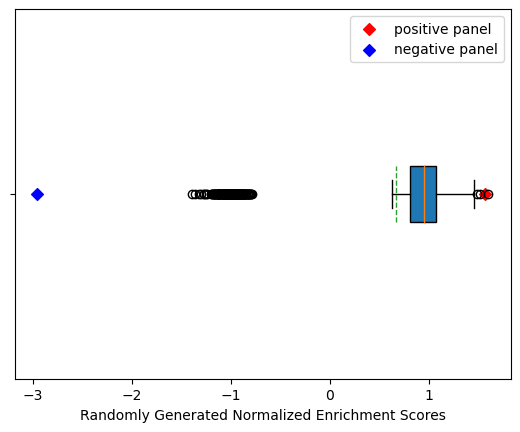

Random list #0
Random list #100
Random list #200
Random list #300
Random list #400
Random list #500
Random list #600
Random list #700
Random list #800
Random list #900
      Name       Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank  random636  0.343088  1.515453       0.0  0.183178      0.171   
1  prerank  random155 -0.358345 -1.509285  0.001592  0.686429      0.494   
2  prerank  random724 -0.348522 -1.469317  0.003339   0.67674      0.746   
3  prerank  random116  0.323219  1.415064  0.007979  0.585393      0.706   
4  prerank  random852  0.315822  1.409965  0.002278  0.431291      0.741   

    Tag %  Gene %                                         Lead_genes  
0  79/250  23.87%  ILMN_1796013;ILMN_1724145;ILMN_1772286;ILMN_16...  
1  54/250  13.77%  ILMN_2118129;ILMN_1744211;ILMN_1812902;ILMN_17...  
2  44/250   9.78%  ILMN_1680996;ILMN_1747344;ILMN_1808657;ILMN_17...  
3  59/250  15.87%  ILMN_1659888;ILMN_1772991;ILMN_1782403;ILMN_16...  
4  41/250  10.45%  I

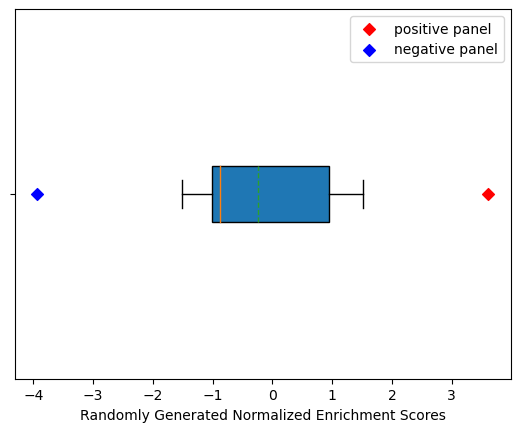

Random list #0
Random list #100
Random list #200
Random list #300
Random list #400
Random list #500
Random list #600
Random list #700
Random list #800
Random list #900


2023-11-25 10:39:07,733 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


      Name       Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank  random800 -0.339331 -1.551182   0.00155  0.405716      0.333   
1  prerank  random414 -0.333693 -1.529784  0.001513  0.306285      0.458   
2  prerank  random420 -0.325534 -1.490769   0.00158   0.40405      0.714   
3  prerank  random467 -0.314968 -1.444564  0.004687  0.636304       0.92   
4  prerank  random865 -0.313179 -1.443065  0.005857  0.521634      0.926   

    Tag %  Gene %                                         Lead_genes  
0  58/250  14.19%  ILMN_1852771;ILMN_2347314;ILMN_1750896;ILMN_21...  
1  64/250  17.60%  ILMN_1752935;ILMN_2087060;ILMN_1782618;ILMN_21...  
2  63/250  16.85%  ILMN_2183938;ILMN_2078466;ILMN_1777449;ILMN_23...  
3  59/250  15.43%  ILMN_1911503;ILMN_1727831;ILMN_1679071;ILMN_17...  
4  58/250  18.21%  ILMN_1794108;ILMN_1778161;ILMN_1750969;ILMN_16...  



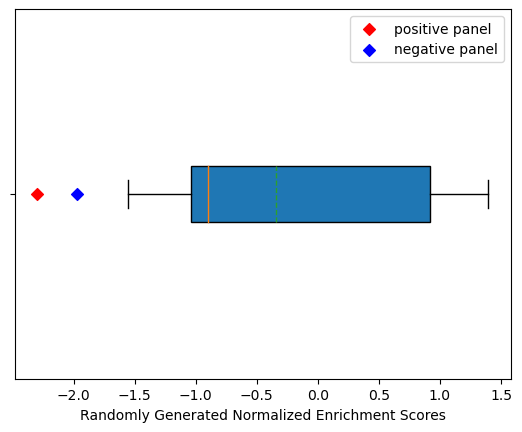

Random list #0
Random list #100
Random list #200
Random list #300
Random list #400
Random list #500
Random list #600
Random list #700
Random list #800
Random list #900
      Name       Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank  random127 -0.424307 -1.500907   0.00274  0.356509      0.322   
1  prerank  random480 -0.410519 -1.453526  0.001399  0.502611      0.651   
2  prerank  random919 -0.391306 -1.379747  0.002755       1.0      0.988   
3  prerank  random562 -0.389012 -1.379227  0.007246       1.0      0.988   
4  prerank  random612  -0.38206 -1.375006  0.009346   0.88399      0.992   

    Tag %  Gene %                                         Lead_genes  
0  46/250  11.67%  ILMN_1775814;ILMN_2086890;ILMN_1773814;ILMN_18...  
1  59/250  15.63%  ILMN_1789463;ILMN_1729216;ILMN_2065745;ILMN_16...  
2  52/250  15.40%  ILMN_1784863;ILMN_1719236;ILMN_1715991;ILMN_17...  
3  61/250  17.68%  ILMN_2210753;ILMN_1678215;ILMN_1807529;ILMN_17...  
4  56/250  15.33%  I

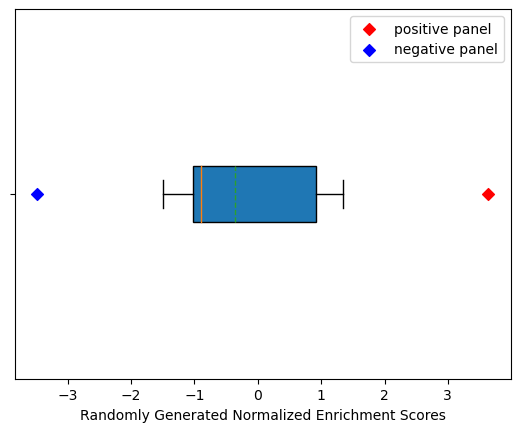

In [21]:
if randomgenemodel == True:
    for output_path in other_datasets_output_path_list: #iterate over comparison datasets
        #bring in other dataset signature
        verify_sig_file = output_path + '\signature.txt'
        verify_sig_df = pd.read_csv(verify_sig_file, low_memory = False, index_col = None, header = 0, sep = '\t')
        verify_sig_df.drop(['Tscore'], axis = 1, inplace = True)
        
        #generate random panels
        randompanel = shuffle(verify_sig_df)
        randompanel.to_csv((output_gene_file_dir + '\\' + 'randompaneldata.gmt'), sep='\t', index=False, header=False)

        #create output directory if one does not exist
        random_output_path = output_path + "\\" + 'random'
        if not os.path.exists(random_output_path):
            os.mkdir(random_output_path)

        #run GSEA to generate null distibution of NES
        dfrandomNES = prerank_GSEA(verify_sig_df, (output_gene_file_dir + '\\' + 'randompaneldata.gmt'), random_output_path, gene_query_set_size) 
                
        #visualize the results
        #first get random model NES
        dfrandomNES = pd.read_csv((random_output_path + "\\" + 'GSEAresults' + "\\" + GSEAresultsfiletitle), low_memory=False)
        dfrandomNEScol = dfrandomNES["NES"]
        
        #next get panel achieved NES
        dfNES = pd.read_csv((output_path + "\\" + 'GSEAresults' + "\\" + GSEAresultsfiletitle), low_memory=False)
        dfNEScol = dfNES["NES"]
        
        pospanel = dfNEScol[1]
        if pospanel < 0:
            negpanel = pospanel
            pospanel = dfNEScol[0]

        else:
            negpanel = dfNEScol[0]

        #box and whiskars the results
        fig, ax = plt.subplots()
        line1 = ax.boxplot(dfrandomNEScol, vert=0, patch_artist=True, meanline=True, showmeans=True)
        line2 = ax.scatter(pospanel, 1, marker="D", color = "red", label = "positive panel")
        line3 = ax.scatter(negpanel, 1, marker="D", color = "blue", label = "negative panel")
        plt.yticks([1], [''])
        plt.xlabel('Randomly Generated Normalized Enrichment Scores')
        ax.legend(handles=[line2, line3])
        saveloc = output_path + '\\randomNESboxwhisplot.png'
        plt.savefig(saveloc, dpi=100)
        plt.show()

else: #randommodel = False
    print('This section has been skipped.')